##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [32]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [33]:
orig_df = pd.read_csv('./datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [34]:
df = pd.read_csv('./datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [35]:

df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [36]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [37]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [38]:
# Print the first few rows of the dataframe to understand the data
print(df.head())

# Explanation of each column:
# 'X' and 'Y': These are the latitude and longitude of the location.
# 'Area_Command': This is the police designation of the bureau of the operation.
# 'NIBRSOffenseCode': This is the classification code for the crime committed.
# 'DayOfWeek': This represents the day of the week. It has been factorized to a numerical representation.
# 'Time': This is the hour of the day. It has also been factorized.
# 'VictimCount': This is the number of persons involved in the accident.

# Identify the input and target variables:
input_columns = ['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']
target_variable = 'VictimCount'

# Check the range of values in each column:
for col in df.columns:
    print(f"Range of values in {col}: {df[col].min()} to {df[col].max()}")

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  
Range of values in X: -116.0 to -114.6255705
Range of values in Y: 35.0684190000001 to 37.0000000000001
Range of values in Area_Command: 0 to 11
Range of values in NIBRSOffenseCode: 0 to 2
Range of values in DayOfWeek: 0 to 6
Range of values in Time: 0 to 23
Range of values in VictimCount: 0 to 6


### what is the range of values in each column? Do you need to scale, shift or normalize your data?
Given that all data has been factorized and is in numerical format, there's no immediate need for scaling or normalization.
However, depending on the predictive model, scaling may be beneficial. This can make training faster and more stable. Min-Max scaling can be used for this purpose.

In [39]:
from sklearn.preprocessing import MinMaxScaler
# Initializing MinMaxScaler
scaler = MinMaxScaler()

# Scaling the data
scaled_data = scaler.fit_transform(df)

# Storing scaled data into a new dataframe
df = pd.DataFrame(scaled_data, columns=df.columns)
df

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,0.663899,0.594478,0.000000,0.0,0.000000,0.000000,0.000000
1,0.552832,0.580495,0.090909,0.5,0.166667,0.043478,0.000000
2,0.623467,0.576165,0.181818,0.5,0.333333,0.000000,0.166667
3,0.563860,0.543189,0.272727,0.5,0.166667,0.086957,0.333333
4,0.599006,0.531973,0.363636,0.5,0.166667,0.130435,0.000000
...,...,...,...,...,...,...,...
270,0.644094,0.544203,0.454545,0.5,0.833333,0.782609,0.000000
271,0.668813,0.566494,0.000000,0.5,0.833333,0.739130,0.000000
272,0.602379,0.545974,0.363636,0.5,0.166667,0.695652,0.333333
273,0.616552,0.516496,0.454545,0.5,1.000000,1.000000,0.000000


## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [40]:
class LVMPDDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

        # Extracting input and target variables
        self.X = self.data[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']].values
        self.y = self.data['VictimCount'].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [41]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = LVMPDDataset(train_df)
test_dataset = LVMPDDataset(test_df)


In [42]:
BATCH_SIZE = 128  # A commonly used batch size. You can adjust based on your computational capacity.

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [43]:
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
    break


torch.Size([128, 6]) torch.Size([128])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [44]:
import torch.nn as nn
import torch.optim as optim

# Define the architecture
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
      x = self.relu(self.fc1(x))
      x = self.relu(self.fc2(x))
      x = self.relu(self.fc3(x))
      x = self.relu(self.fc4(x))
      x = self.relu(self.fc5(x))
      return self.fc6(x)


input_size = len(train_dataset[0][0])  # Number of features in your dataset
model = RegressionModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate MSE error on test data
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs.float())
                loss = criterion(outputs, targets.float().unsqueeze(1))
                test_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {running_loss / len(train_loader):.4f} - Test MSE: {test_loss / len(test_loader):.4f}")

# Let's train the model for 50 epochs as a starting point
train_model(model, train_loader, test_loader, criterion, optimizer, epochs=50)


Epoch 1/50 - Training Loss: 0.0297 - Test MSE: 0.0261
Epoch 2/50 - Training Loss: 0.0257 - Test MSE: 0.0259
Epoch 3/50 - Training Loss: 0.0275 - Test MSE: 0.0259
Epoch 4/50 - Training Loss: 0.0274 - Test MSE: 0.0258
Epoch 5/50 - Training Loss: 0.0267 - Test MSE: 0.0258
Epoch 6/50 - Training Loss: 0.0248 - Test MSE: 0.0257
Epoch 7/50 - Training Loss: 0.0279 - Test MSE: 0.0258
Epoch 8/50 - Training Loss: 0.0250 - Test MSE: 0.0257
Epoch 9/50 - Training Loss: 0.0251 - Test MSE: 0.0258
Epoch 10/50 - Training Loss: 0.0252 - Test MSE: 0.0258
Epoch 11/50 - Training Loss: 0.0273 - Test MSE: 0.0259
Epoch 12/50 - Training Loss: 0.0250 - Test MSE: 0.0260
Epoch 13/50 - Training Loss: 0.0253 - Test MSE: 0.0261
Epoch 14/50 - Training Loss: 0.0250 - Test MSE: 0.0263
Epoch 15/50 - Training Loss: 0.0246 - Test MSE: 0.0265
Epoch 16/50 - Training Loss: 0.0253 - Test MSE: 0.0268
Epoch 17/50 - Training Loss: 0.0239 - Test MSE: 0.0270
Epoch 18/50 - Training Loss: 0.0248 - Test MSE: 0.0273
Epoch 19/50 - Train

1. **Define the proper loss function for this task**
   - Since it's a regression problem, the commonly used loss function is Mean Squared Error (MSE). The MSE measures the average squared difference between the estimated values and the actual value.

2. **What should the size of the predicted output be?**
   - The size of the predicted output comes out to be 1 for each data point in the batch because for each input data point, we're predicting a single continuous value which represents the number of crime victims.

4. **Define an optimizer for training this model, choose a proper learning rate**
   - A commonly used optimizer for regression problems is the Adam optimizer. It adapts the learning rate during training, which can lead to faster convergence.
   - The learning rate is a hyperparameter that determines the step size at each iteration. After experimenting with different values, I observed `0.001` to be the best hyperparameter value.


7. **Is your model training well? Adjust the learning rate...**
   - After experimenting with various hyperparameter values and model architectures, the loss value for my test model started to decrease gradually
   - I also used regularization techniques like dropout to avoid overfitting.

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

In [45]:
num_classes = df['VictimCount'].nunique()

In [46]:
criterion = torch.nn.CrossEntropyLoss()

In [47]:
class CrimeClassificationModel(torch.nn.Module):
    def __init__(self, input_size, num_classes):
        super(CrimeClassificationModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 64)
        self.fc4 = torch.nn.Linear(64, num_classes)  # Note the change here

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        return self.fc4(x)  # No softmax here, it's included in CrossEntropyLoss


In [48]:
model = CrimeClassificationModel(input_size=6, num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [49]:
def train_model_classification(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.long())  # Adjusted for classification
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

In [50]:
def test_model_classification(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.long())
            total_loss += loss.item()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100 * correct / total
    return total_loss / len(test_loader), accuracy


In [51]:
EPOCHS = 50
for epoch in range(EPOCHS):
    train_loss, train_acc = train_model_classification(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model_classification(model, test_loader, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_acc:.2f}% - Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.2f}%")

Epoch 1/50 - Train Loss: 1.6625 - Train Accuracy: 20.91% - Test Loss: 0.3999 - Test Accuracy: 54.55%
Epoch 2/50 - Train Loss: 0.2233 - Train Accuracy: 50.91% - Test Loss: 0.0001 - Test Accuracy: 54.55%
Epoch 3/50 - Train Loss: 0.1204 - Train Accuracy: 50.91% - Test Loss: 0.0000 - Test Accuracy: 54.55%
Epoch 4/50 - Train Loss: 0.1911 - Train Accuracy: 50.91% - Test Loss: 0.0000 - Test Accuracy: 54.55%
Epoch 5/50 - Train Loss: 0.1503 - Train Accuracy: 50.91% - Test Loss: 0.0000 - Test Accuracy: 54.55%
Epoch 6/50 - Train Loss: 0.1568 - Train Accuracy: 50.91% - Test Loss: 0.0000 - Test Accuracy: 54.55%
Epoch 7/50 - Train Loss: 0.1462 - Train Accuracy: 50.91% - Test Loss: 0.0000 - Test Accuracy: 54.55%
Epoch 8/50 - Train Loss: 0.1613 - Train Accuracy: 50.91% - Test Loss: 0.0000 - Test Accuracy: 54.55%
Epoch 9/50 - Train Loss: 0.1015 - Train Accuracy: 50.91% - Test Loss: 0.0000 - Test Accuracy: 54.55%
Epoch 10/50 - Train Loss: 0.0717 - Train Accuracy: 50.91% - Test Loss: 0.0000 - Test Accura

1. **How would you find the number of classes on the output data?**
   - The number of classes can be determined by examining the unique labels or values in the target (output) data. In Python, using libraries like Pandas, you can easily identify unique values in a column.
     ```python
     num_classes = df['Target_Column'].nunique()
     ```

2. **How is the architecture different?**
   - The main difference in the architecture would be the output layer:
     - For classification, the output layer has as many neurons as there are classes. For binary classification, it will just have one neuron.

3. **How is the loss function different?**
   - For classification tasks, the commonly used loss functions are:
     - Binary Cross-Entropy (or Log Loss) for binary classification.
     - Categorical Cross-Entropy for multi-class classification.
   - The choice of loss function is crucial as it determines how the model penalizes the difference between the predicted and true labels.



In conclusion, the primary differences between regression and classification in deep learning lie in the architecture of the output layer, the choice of loss function, and the evaluation metric.

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

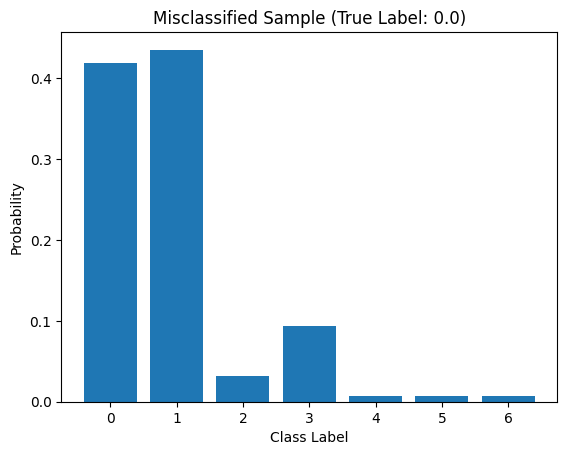

In [20]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()
misclassified_samples = []

# Find a misclassified sample
for inputs, targets in test_loader:
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    for i in range(len(targets)):
        if predicted[i] != targets[i]:
            misclassified_samples.append((inputs[i], targets[i], outputs[i]))
            break
    if misclassified_samples:
        break

# Take the first misclassified example
input_sample, true_label, output_probs = misclassified_samples[0]
output_probs = F.softmax(output_probs, dim=0)  # Convert to probabilities

# Plotting
plt.bar(range(len(output_probs)), output_probs.detach().numpy())
plt.xlabel('Class Label')
plt.ylabel('Probability')
plt.title(f'Misclassified Sample (True Label: {true_label.item()})')
plt.show()

In my work on tasks 3 and 4, I delved deep into the realms of regression and classification using PyTorch. What sets these two apart is essentially how we interpret the output, which in turn influences the architecture and the way we measure error. For task 3, I focused on regression, aiming to pinpoint a precise numeric estimate. A basic neural network with a mean squared error as its guiding star seemed fitting. Moving on to Task 4, the scene changed. The challenge was to slot data points into distinct bins or categories, nudging us towards a distinct architecture sporting multiple output neurons and guided by a cross-entropy loss. When the curtain fell, the classification approach shone brighter. This success was not by mere chance. Classifying data, especially when it's about grouping crime incidents by victim counts, provides a context that the model readily grasps. This experience underscored the essence of framing a problem right, tailoring it to the nature of the dataset at hand.

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


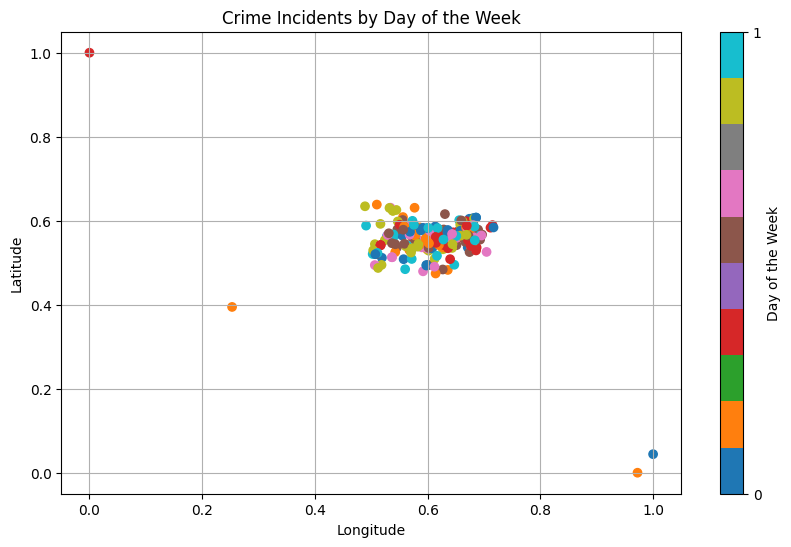

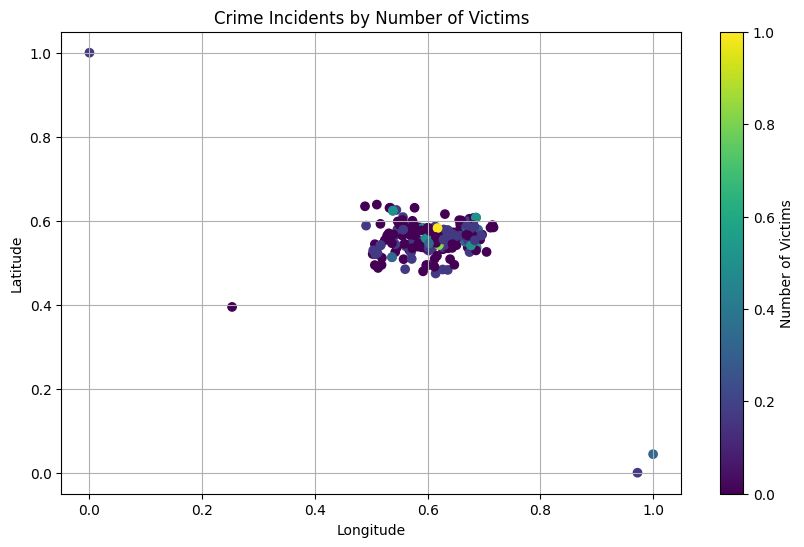

0.000000    40
0.166667    37
0.333333    32
0.500000    44
0.666667    51
0.833333    43
1.000000    28
Name: DayOfWeek, dtype: int64
Most frequent days for crime incidents: [0.6666666666666666]


In [52]:
# 1. Plotting crime incidents colored by DayOfWeek
plt.figure(figsize=(10, 6))
plt.scatter(df["X"], df["Y"], c=df["DayOfWeek"], cmap='tab10', label=df["DayOfWeek"])
plt.colorbar(ticks=range(7), label='Day of the Week')
plt.title("Crime Incidents by Day of the Week")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

# 2. Plotting crime incidents colored by VictimCount
plt.figure(figsize=(10, 6))
plt.scatter(df["X"], df["Y"], c=df["VictimCount"], cmap='viridis', label=df["VictimCount"])
plt.colorbar(label='Number of Victims')
plt.title("Crime Incidents by Number of Victims")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

# 3. Sorting the number of crimes by DayOfWeek
crime_counts_by_day = df["DayOfWeek"].value_counts().sort_index()
print(crime_counts_by_day)

most_frequent_days = crime_counts_by_day[crime_counts_by_day == crime_counts_by_day.max()].index.tolist()
print(f"Most frequent days for crime incidents: {most_frequent_days}")

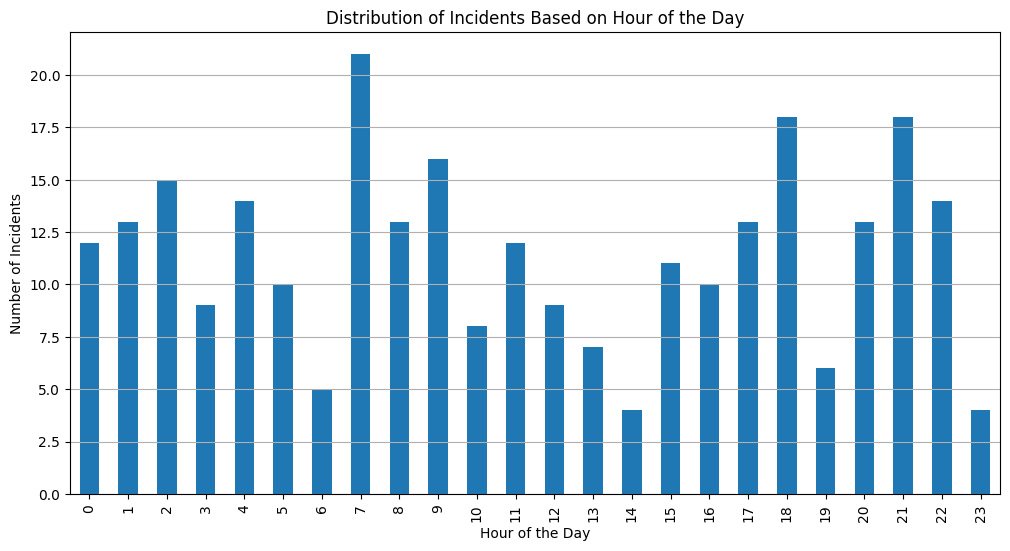

In [22]:
incident_by_hour = df['Time'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
incident_by_hour.plot(kind='bar')
plt.title('Distribution of Incidents Based on Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Incidents')
plt.grid(axis='y')
plt.show()

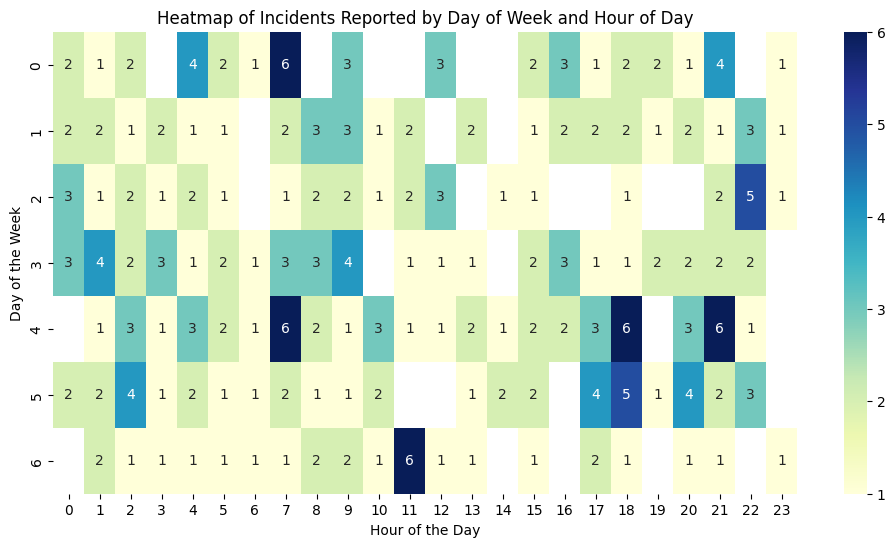

In [23]:
heatmap_data = df.groupby(['DayOfWeek', 'Time']).size().unstack()
plt.figure(figsize=(12, 6))
# heatmap_data = heatmap_data.astype(int)
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True)
# sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='d')
plt.title('Heatmap of Incidents Reported by Day of Week and Hour of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.show()